In [1]:
import datetime
import os
import pandas as pd
import numpy as np 
from statistics import mean
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold, RandomizedSearchCV
from scipy.stats import uniform, randint
import random
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance

from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor

In [2]:
# Load dataset
def load_data(file_path, target_column):
    df = pd.read_csv(file_path)
    X = df.drop(columns=[target_column])
    y = df[target_column]
    return df, X, y

# Correlation heatmap
def plot_correlation(df):
    plt.figure(figsize=(12, 8))
    sns.heatmap(df.corr(), annot=True, fmt='.2f', cmap='coolwarm')
    plt.title('Correlation Heatmap')
    plt.show()

# Evaluate model
def evaluate_model(y_true, y_pred):
    global mse, r2, mae, mape, rmse
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    return {
        "R2": r2,
        "MAE": mae,
        "MSE": mse,
        "MAPE": mape,
        "RMSE": rmse
    }

# Permutation feature importance
def plot_permutation_importance(model, X, y, feature_names):
    result = permutation_importance(model, X, y, n_repeats=10, random_state=42, scoring='r2')
    sorted_idx = result.importances_mean.argsort()[::-1]
    
    save_directry = "C:\\WorkSpace\\Practice\\ensenmble learning\\result"
    os.makedirs(save_directry, exist_ok=True)

    global currenttime
    currenttime = datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
    file_name = os.path.join(save_directry ,f"{currenttime}.png")

    plt.figure(figsize=(10, 6))
    plt.bar(range(len(feature_names)), result.importances_mean[sorted_idx], align='center')
    plt.xticks(range(len(feature_names)), feature_names[sorted_idx], rotation=90)
    plt.title('Permutation Feature Importance')
    plt.savefig(file_name, bbox_inches='tight')
    plt.show()


In [3]:
# Feature Selection
def feature_selection(X, y):
    
    # 特徴量の総数を取得
    total_features = X.shape[1]

    # 特徴量の数を変えてSFSを実施し、最も良い精度を持つモデルを選択
    best_score = float('inf')
    best_num_features = total_features
    best_selector = None

    for num_features in range(total_features-1, 0, -1):  # total_features - 1 まで
        estimator = SVR(kernel="rbf")
        selector = SequentialFeatureSelector(
            estimator, 
            n_features_to_select=num_features, 
            direction='forward'
            # direction='backward'
        )
        
        # X_scaledがまだ定義されていない場合は、ここで定義する
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
        
        selector = selector.fit(X_scaled, y)
        
        X_selected = X.iloc[:, selector.get_support()]
        X_selected_scaled = scaler.fit_transform(X_selected)
        
        # GridSearchCVによるハイパーパラメータの調整
        param_grid = {
            'C': [0.1, 1, 10],
            'epsilon': [0.01, 0.1, 1],
            'gamma':[0.1, 1, 'auto']
        }

        grid_search = GridSearchCV(SVR(kernel='rbf'), param_grid, cv=5, scoring='neg_mean_squared_error')
        grid_search.fit(X_selected_scaled, y)
        
        # 最適なハイパーパラメータでのモデルの評価
        best_svr = grid_search.best_estimator_
        # kfold = KFold(n_splits=len(data), shuffle=True, random_state=42)
        cv_results = cross_val_score(best_svr, X_selected_scaled, y, cv=5, scoring='neg_mean_squared_error')
        mean_score = -cv_results.mean() #もしscoringが'neg_mean_squared_error'ならば、cv_resultを負の値(-cv_result)にする
        
        if mean_score < best_score: #もしscoringが'neg_mean_squared_error'ならば、mean_score < best_scoreに書き換える
            best_score = mean_score
            best_num_features = num_features
            best_selector = selector

    # 最適な特徴量数で再構築
    X_selected = X.iloc[:, best_selector.get_support()]
    X_selected_scaled = scaler.fit_transform(X_selected)
    print(f'Best number of features: {best_num_features}')
    print(f'Selected features: {X.columns[best_selector.get_support()].tolist()}')
    print(f'Best mean squared error: {best_score}')

    return X_selected, best_num_features, X.columns[best_selector.get_support()].tolist()


In [4]:
# Main function
def main(file_path, target_column):
    global df, X, y
    df, X, y = load_data(file_path, target_column)

    # Plot correlation heatmap
    plot_correlation(df)

    # Feature Selection
    global best_num_features, selected_features
    X_selected, best_num_features, selected_features  = feature_selection(X, y)

    # Split dataset
    X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)
    
    # Scale the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Base models
    global base_models
    base_models = [
    ('ridge', Ridge()),
    ('rf', RandomForestRegressor()),
    ('svr', SVR()),
    ('mlp', MLPRegressor())
    ]

    """ param_grids = {
        'ridge__alpha':[0.1, 1.0, 10.0],
        'svr__C':[0.1, 1, 10],
        'svr__epsilon':[0.1, 0.2, 0.5],
        'svr__kernel':['rbf'],
        'mlp__hidden_layer_sizes':[(64,), (64, 32)],
        'mlp__activation':['relu', 'tanh'],
        'mlp__max_iter':[200, 500],
        'rf__n_estimators':[50, 100, 200],
        'rf__max_depth':[None, 10, 20],
        'final_estimator':[GradientBoostingRegressor(random_state=42)]
    } """

    param_dist = {
        'svr__C':uniform(5, 12),
        'svr__epsilon':uniform(0.01, 1),
        'mlp__max_iter':randint(200, 500),
        'rf__max_depth':randint(3, 8),
        'final_estimator__max_depth':randint(1, 5)
    }

    # Stacking Regressor
    stack_model = StackingRegressor(
        estimators=base_models,
        final_estimator=GradientBoostingRegressor()
    )

    """ # Tune models using GridSearchCV
    global best_estimators
    best_estimators = {}
    for model_name, model in base_models:
        print(f"Tuning {model_name}...")
        grid_search = GridSearchCV(estimator=model, param_grid=param_grids[model_name], cv=5, scoring='r2', n_jobs=-1)
        grid_search.fit(X_train_scaled, y_train)
        print(f"Best params for {model_name}: {grid_search.best_params_}")
        best_estimators[model_name] = grid_search.best_estimator_ """
    
    random_search = RandomizedSearchCV(estimator=stack_model, param_distributions=param_dist, n_iter=50, cv=5, scoring='r2', random_state=42)
    random_search.fit(X_train_scaled, y_train)
    print(random_search.best_params_)

    global params
    params = random_search.best_params_

    final_model = random_search.best_estimator_
    final_model.fit(X_train_scaled, y_train)
    
    y_pred = final_model.predict(X_test_scaled)
    metrics = evaluate_model(y_test, y_pred)
    for metric, value in metrics.items():
        print(f"{metric}: {value:.4f}")

    # Plot feature importance using permutation importance
    plot_permutation_importance(final_model, X_test_scaled, y_test, X_selected.columns)

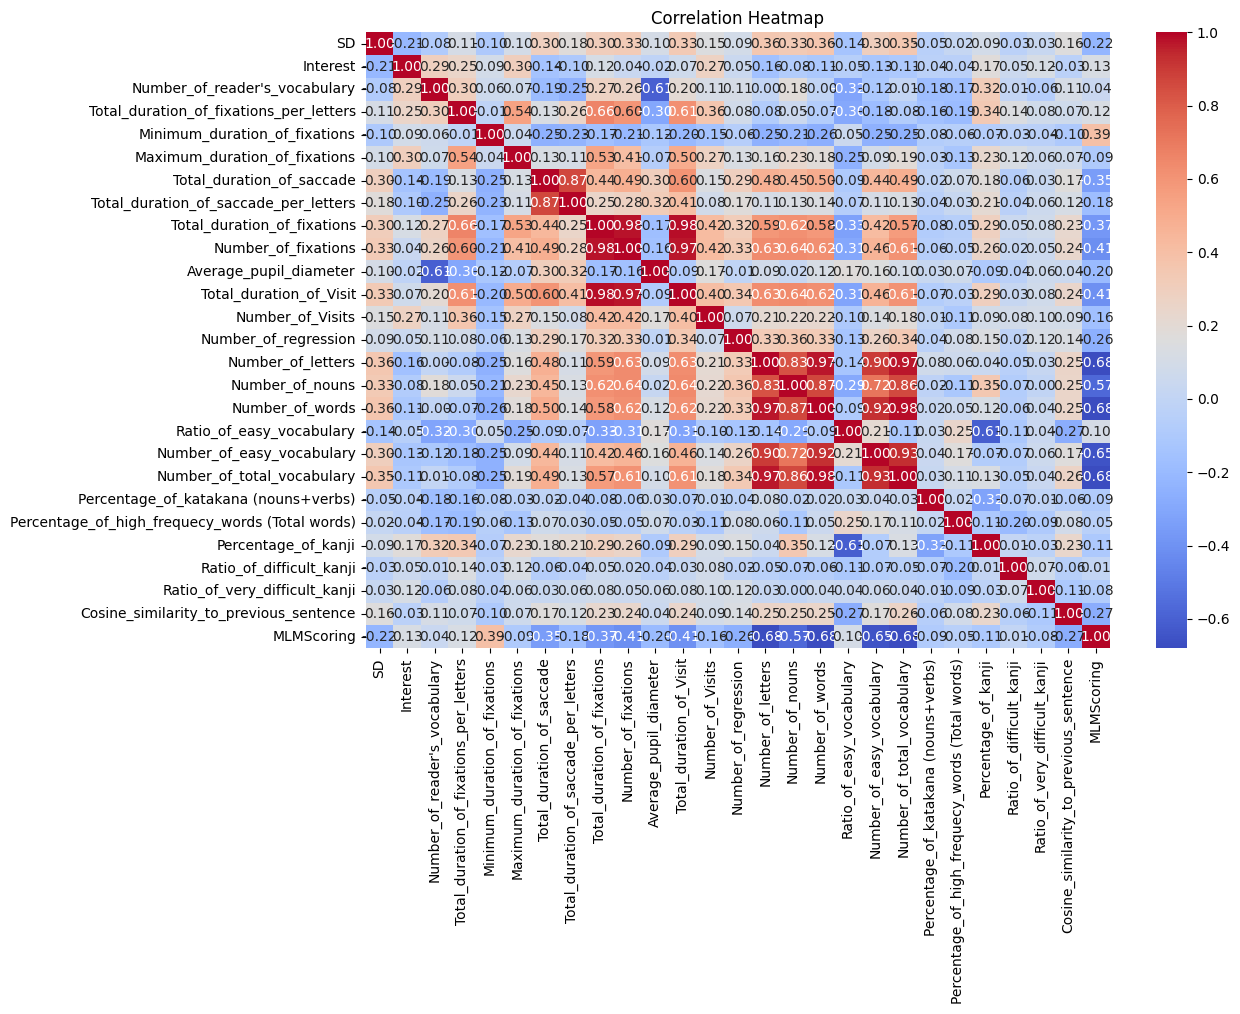

KeyboardInterrupt: 

In [5]:
# Run the script
if __name__ == "__main__":
    file_path = "C:/Users/thisi/OneDrive/共有ファイル/Ensemble_test/Dataset_test.csv"  # Replace with your dataset file path
    target_column = "SD"  # Replace with your target column name
    main(file_path, target_column)

#     selected_features = feature_selection(X, y)

    model_names = [name for name, _ in base_models]
    data_shape = df.shape

    data = {'Data shape': [data_shape],
            'Models': [model_names],
            
            'Best number of features': best_num_features,
            'Slected Features': [selected_features],
            'Model Params':[params],
            'r2': r2,
            'mae': mae,
            'mse': mse,
            'mape' : mape,
            'rmse' : rmse,
            'Date': currenttime,
            'Dataset' : file_path
            }

    new_data = pd.DataFrame(data)

    new_data.to_csv('C:/WorkSpace/Practice/ensenmble learning/result/result_RS.csv', mode='a', header=False, index=False)